# Skin Pathway States Analysis -- Interactive

Here, we analyze pathway states based on already processed skin/epithelial tissue scRNA-seq data from He et al. in their paper [__"The changing mouse embryo transcriptome at whole tissue and single-cell resolution."__ ](https://www.nature.com/articles/s41586-020-2536-x).

Here, we present a virtual interactive environment to visualize distinct pathway states/motifs in scRNA-seq data. The data has been previously analyzed (quality-control, normalization, visualization and clustering).

In [1]:
import warnings # ignores warnings that pop up during import
warnings.filterwarnings("ignore")

import scanpy as sc # scanpy package for scRNA-seq data analysis
import pandas as pd 
import numpy as np

# Just some parameters to format matplotlib plots
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.axes._axes import _log as matplotlib_axes_logger 
import matplotlib.font_manager
matplotlib.rcParams['font.family'] = "calibri" # set font for all figures
from matplotlib.figure import Figure # for panel plots
from matplotlib.backend_bases import FigureCanvasBase # for panel plots

import module as md  # a module I wrote for the analysis

# panel is a package that allows interactive plotting
import panel as pn 
pn.extension() # this line activates panel in Jupyter

import glob # allows us to locate files

In [2]:
# Here, we adjust parameters and formatting of cells' output.
import logging

matplotlib_axes_logger.setLevel('ERROR') # ignores weird color not available warnings that pop up

# Set on Scanpy's verbose output
sc.settings.verbosity = 3   # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

# Set our directory where our data is stored.
resdir = './forelimb/results/'

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.7.1 leidenalg==0.7.0


Below, we import our previously analyzed skin AnnData object.

In [3]:
skin = sc.read(resdir+"skin.h5ad")
skin

AnnData object with n_obs × n_vars = 3341 × 4037
    obs: 'batch', 'stage', 'cell_type', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'slingPseudotime_1', 'slingPseudotime_2', 'slingPseudotime_3', 'Wnt Ligands', 'Wnt Receptors', 'BMP Ligands', 'BMP Receptors', 'Notch', 'Wnt Ligands 0.05', 'Wnt Receptors 0.05', 'BMP Ligands 0.05', 'BMP Receptors 0.05', 'Notch 0.05'
    var: 'n_cells', 'n_cells_per_gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'BMP Ligands 0.05_colors', 'BMP Ligands_colors', 'BMP Receptors 0.05_colors', 'BMP Receptors_colors', 'Notch 0.05_colors', 'Notch_colors', 'Wnt Ligands 0.05_colors', 'Wnt Ligands_colors', 'Wnt Receptors 0.05_colors', 'Wnt Receptors_colors', 'batch_colors', 'cell_type_colors', 'draw_graph', 'leiden', 'leiden_colors'

In [4]:
# We need to identify our genes of interest that are in our skin dataset, as not all are present after filtering genes.

wnt_ligands = md.get_genes(skin, md.wnts)
wnt_receptors = md.get_genes(skin, md.wntr)
bmp_ligands = md.get_genes(skin, md.bmps)
bmp_receptors = md.get_genes(skin, md.bmpr)
notch = md.get_genes(skin, md.notch)

# Store genes in a dictionary for easy access later.
pathways = {'Wnt Ligands': wnt_ligands, 'Wnt Receptors': wnt_receptors, 'BMP Ligands': bmp_ligands,
           'BMP Receptors': bmp_receptors, 'Notch': notch}

We can visualize the skin dataset by plotting the UMAP dimensionality reduction. We can label the skin cells by clusters generated based on gene expression similarity, termed "Leiden clusters," and we can also label the skin cells by their cell type given in the metadata from He et al.

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


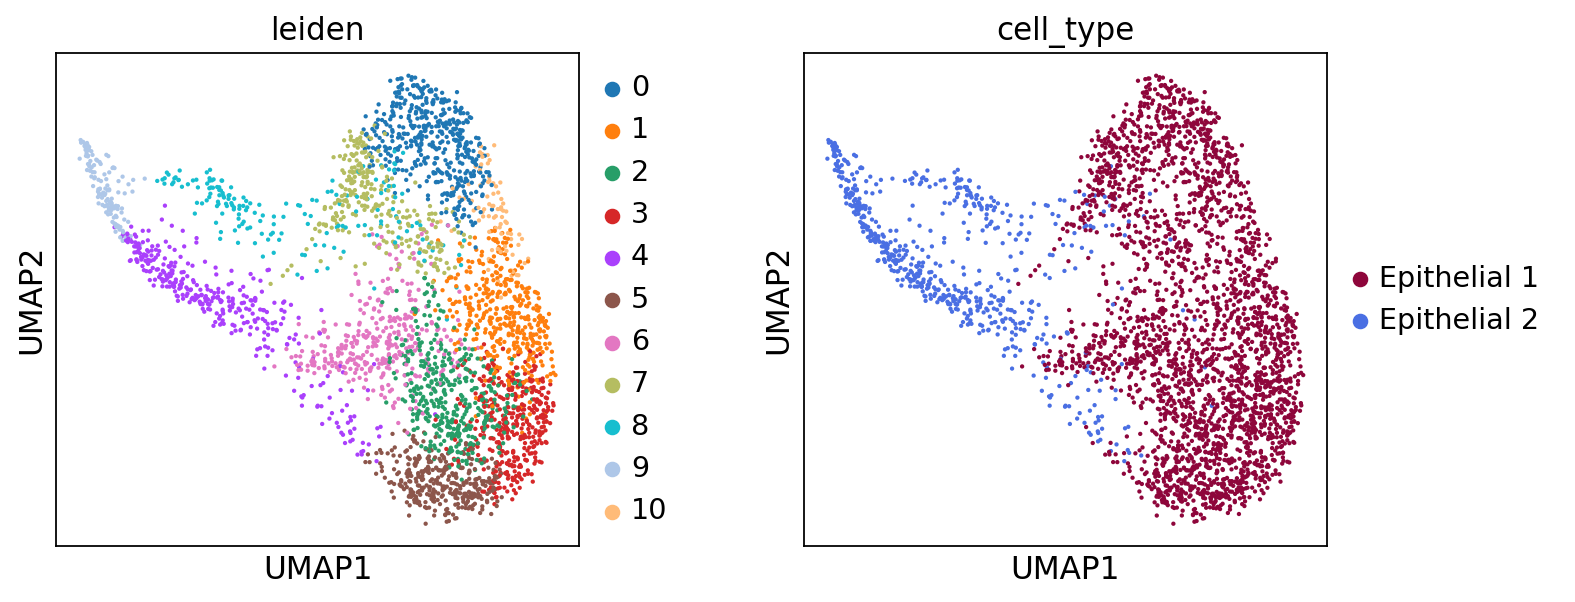

In [5]:
sc.pl.umap(skin, color = ["leiden","cell_type"], size=15, wspace=0.3)

### Pathway States Analysis <a class="anchor" id="14-bullet"></a>

We can analyze for motifs/states in average gene expression in pathways for interest within this skin dataset. Specifically, we can quickly check this by applying a simple cosine distance metric to cluster average gene expression in pathways of interest amongst our Leiden clusters.

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
... storing 'Wnt Ligands' as categorical
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


Column
    [0] Markdown(str, align='center', style={'font-family': '...})
    [1] Markdown(str, align='center', style={'font-family': '...})
    [2] Column(align='center')
        [0] Row(align='center')
            [0] Column(align='center')
                [0] ParamFunction(function)
                [1] ParamFunction(function)
            [1] Column(align='center')
                [0] Column(align='center')
                    [0] Select(name='Pathway', options=['Wnt Ligands', ...], value='Wnt Ligands', width=150)
                    [1] IntSlider(end=10, name='Number of Pathway C..., start=2, value=2, width=250)
                [1] Spacer(height=10)
                [2] ParamFunction(function)
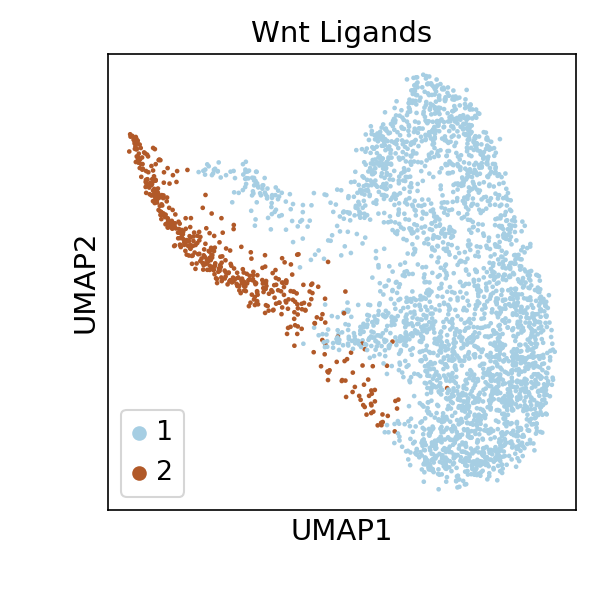
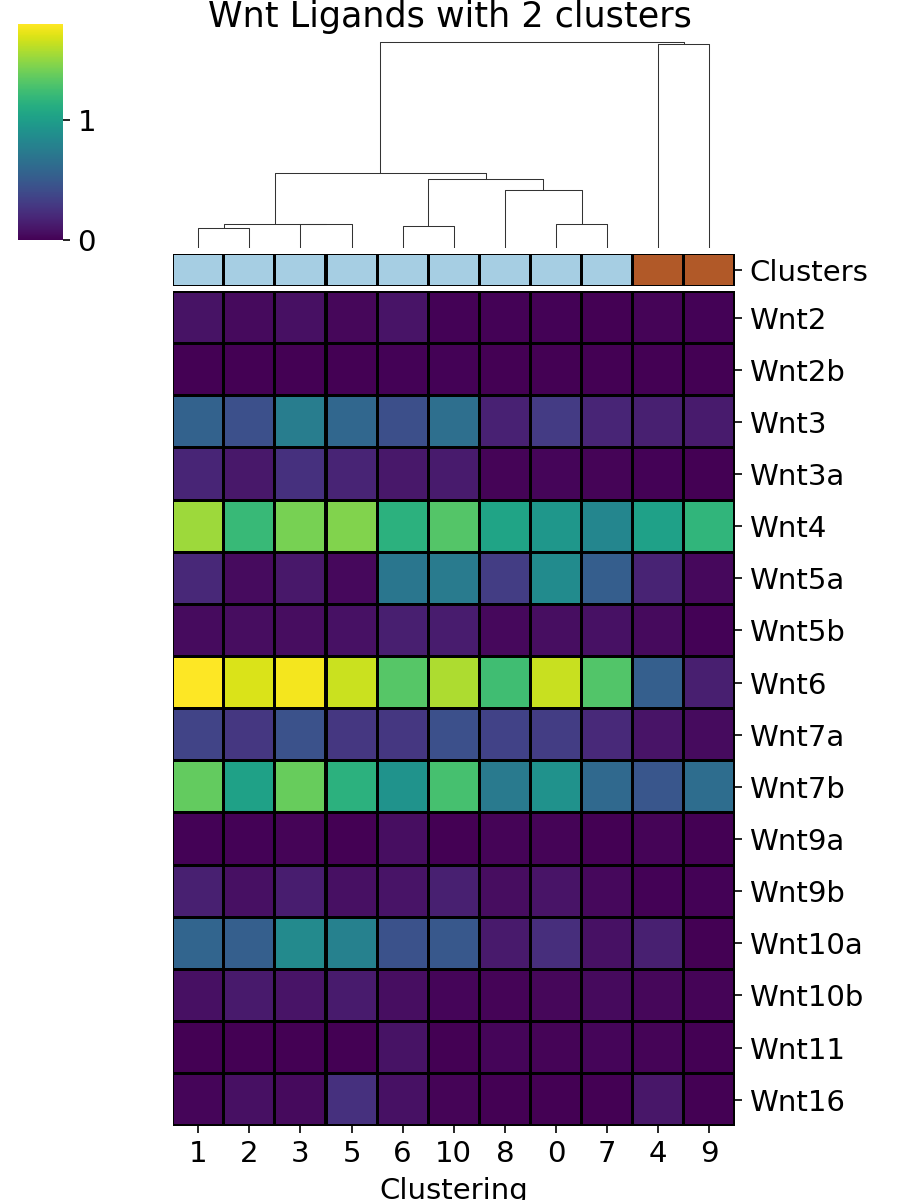
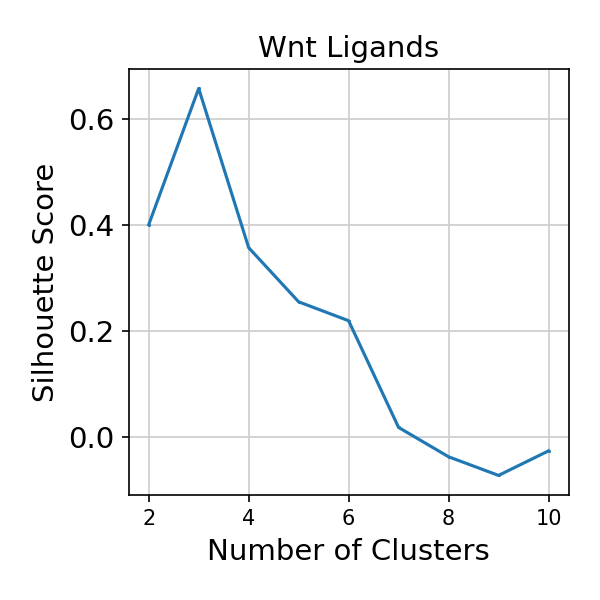

In [6]:
ticker = pn.widgets.Select(name='Pathway', options=list(pathways.keys()), width=150)
int_slider = pn.widgets.IntSlider(name='Number of Pathway Clusters', 
                                  start = 2, end=len(skin.obs['leiden'].unique())-1,
                                 width=250)

@pn.depends(ticker.param.value)

def get_silhouette(ticker_val):
    genes = pathways[ticker_val]
    fig = md.silhouette_plots(skin, ticker_val, genes)[0]
    fig.set_size_inches(4,4)
    plt.close()
    return fig

@pn.depends(ticker.param.value, int_slider.param.value)

def get_heatmap(ticker_val, slider_val): 
    genes = pathways[ticker_val]
    xyz = md.heatmap(skin, genes, slider_val, ticker_val, norm=True, figsize=(6,8))
    g = xyz[0]
   # g.set_size_inches(6,8)
    plt.close()
    return g

@pn.depends(ticker.param.value, int_slider.param.value)

def get_umap(ticker_val, slider_val):
    fig = Figure()
    fig.set_size_inches(4,4)
    ax = fig.subplots()
    FigureCanvasBase(fig)
    sc.pl.umap(skin, color = ticker_val, ax=ax, show=True, size = 20)#, palette=skin.uns[ticker_val+'_colors'])
   
    ax.legend()
    ax.set_title(ticker_val)
    return fig

row1 = pn.Column(ticker, int_slider,align='center')
row3 = pn.Column(row1, pn.Spacer(height=10),get_heatmap,align='center')
col1 = pn.Column(get_silhouette, get_umap, align='center')
row2 = pn.Row(col1, row3, align='center')

col=pn.Column(row2, align='center')

panel_layout = pn.Column(pn.pane.Markdown("##Pathway Clusters", align="center", 
                                          style={'font-family': 'Calibri (Body)'}), 
                         pn.pane.Markdown("We can apply a simple Cosine metric to just check by eye whether \
                         there are distinct pathway states in the skin dataset. \n You can select which patwhay \
                         to analyze, and select an ideal number of clusters based on silhouette scores. \
                         It takes a few seconds for this applet to update, so please be patient after updating \
                        the pathway clickbox or the slider for the cluster number.",
                                          align="center", 
                                          style={'font-family': 'Calibri (Body)'}),
                         col)
panel_layout

The simple cosine clustering indicates there are pathway states, but as we can see from the heatmaps, gene expression data is noisy, and our clusters are not well defined. We can define a different distance metric (we use cosine here) that more accurately cluster noisy gene expression data. 

We can account for the noise in our gene expression data by performing a differential gene expression test that allows us to determine which genes are significantly differently expressed between two clusters. 

Specifically, we can define a distance metric for our clustering: for n genes expressed in Leiden clusters *x* and *y*, the distance is defined as

$$d_{i,j} = \frac{\sum_{i=1}^{n} w_ix_iy_i}{{\sum_{i=1}^{n} x_i^2}{\sum_{i=1}^{n} y_i^2}},$$
where x and y are $n \times 1$ vectors of normalized gene expression, and $w$ is a $n \times 1$ weight vector of differential expression of the n genes between vectors x and y, where

$w_i =
  \begin{cases}
    1 &\text{if } p_i < \alpha\\\\
    0 &\text{otherwise}
  \end{cases}
$

We can define this metric by conducting differential expression testing in all pairwise combinations of Leiden clusters. This analysis was already conducted using the DE Single package (R), and we upload these results as .csv files below.

In [7]:
# We can set a significance level for our differential gene expression testing
pvalue = 5e-2

In [8]:
# Import the DE test results
files = glob.glob(resdir+'DE_single_results/*.csv') #format the directories as necessary
prefix_to_drop = resdir+"DE_single_results/"

# We need to format our differential gene expression results
# For each pathway of genes, we can make a upper triangular dataframe that stores the weight matrix w 
# for each pairwise combination of Leiden clusters.

leiden_list = list(skin.obs['leiden'].unique())
leiden_list.sort()

pathways_p_vals = dict([(key, pd.DataFrame(object,columns=leiden_list,
                                          index=leiden_list)) for
                       key in list(pathways.keys())])

for file_name in files:
    split_filename1 = file_name.split(prefix_to_drop)
    split_filename2 = split_filename1[1].split("_")
    first_leiden = split_filename2[0]
    second_leiden = split_filename2[1].split(".csv")[0]
    file = pd.read_csv(file_name, index_col=[0])
    count=0
    for gene_list in pathways_p_vals.keys():
        temp = list(file.loc[file.index.isin(pathways[gene_list])][file.loc[file.index.isin(pathways[gene_list])]["pvalue.adj.FDR"] < pvalue]["pvalue.adj.FDR"].index)
        weight_vector = []
        for idx, item in enumerate(pathways[gene_list]):
            if item in temp:
                weight_vector.append(1.0)
            else:
                weight_vector.append(0.0)
        if (int(first_leiden) < int(second_leiden)):
            pathways_p_vals[gene_list].loc[first_leiden][second_leiden] = weight_vector
        else:
            pathways_p_vals[gene_list].loc[second_leiden][first_leiden] = weight_vector

... storing 'Wnt Ligands' as categorical
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


Column
    [0] Markdown(str, align='center', style={'font-family': '...})
    [1] Markdown(str, align='center', style={'font-family': '...})
    [2] Column(align='center')
        [0] Row(align='center')
            [0] Column(align='center')
                [0] ParamFunction(function)
                [1] ParamFunction(function)
            [1] Column(align='center')
                [0] Column(align='center')
                    [0] Select(name='Pathway', options=['Wnt Ligands', ...], value='Wnt Ligands', width=150)
                    [1] IntSlider(end=10, name='Number of Pathway C..., start=2, value=2, width=250)
                [1] Spacer(height=10)
                [2] ParamFunction(function)
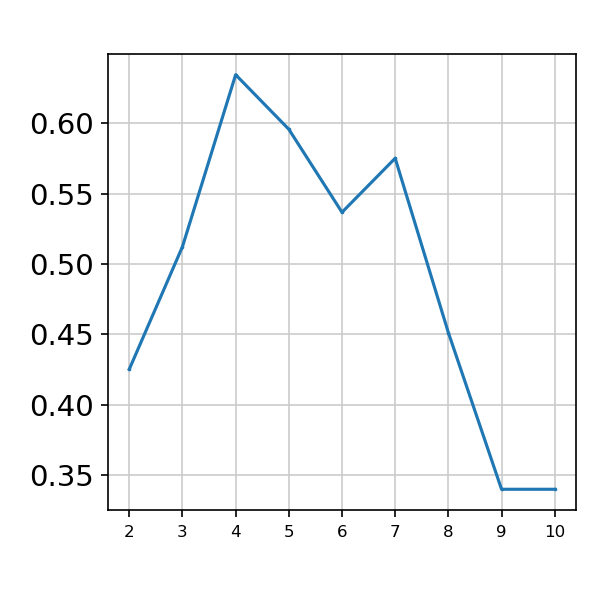
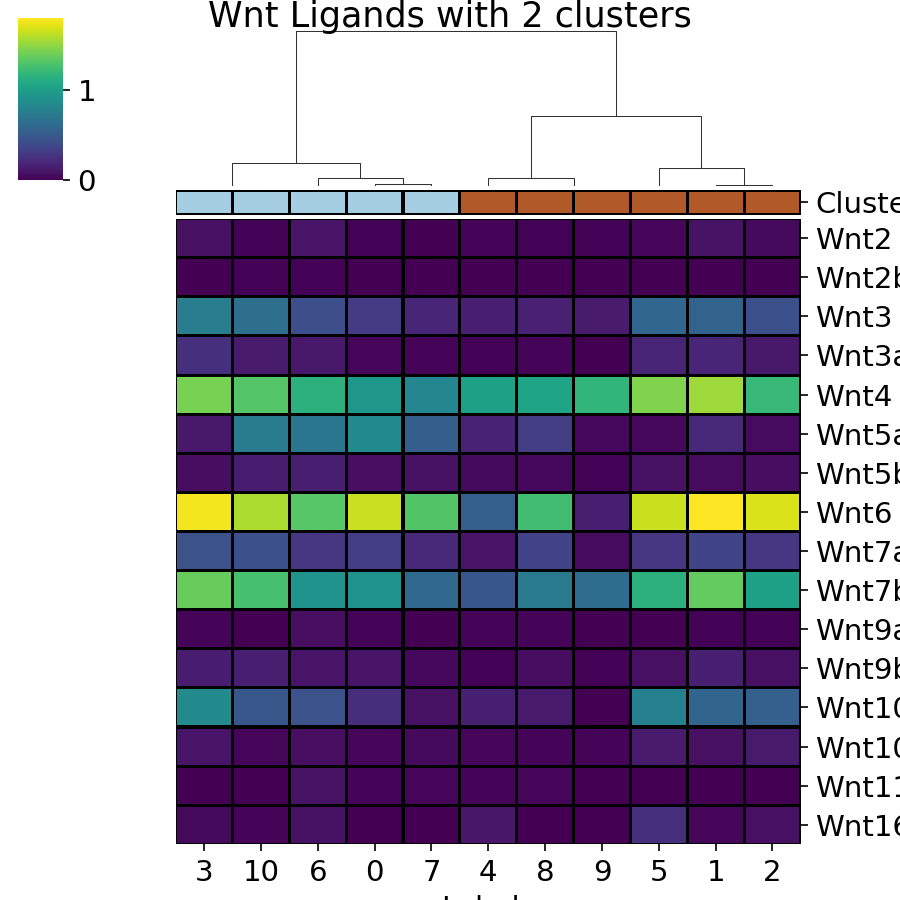
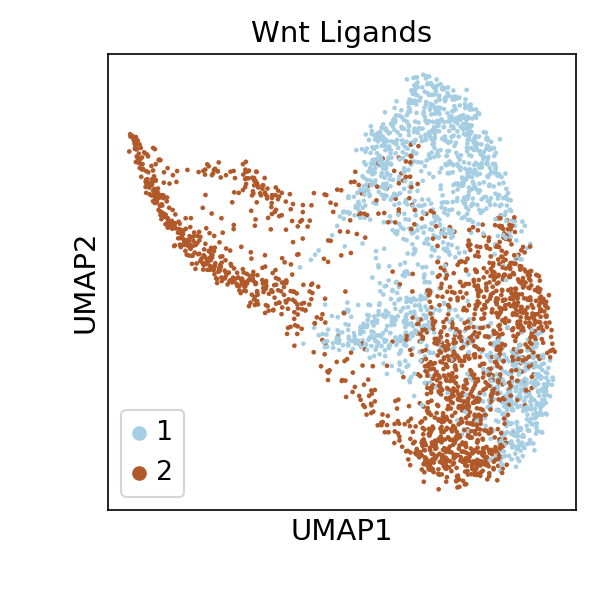

In [9]:
ticker = pn.widgets.Select(name='Pathway', options=list(pathways.keys()), width=150)
int_slider = pn.widgets.IntSlider(name='Number of Pathway Clusters', 
                                  start = 2, end=len(skin.obs['leiden'].unique())-1,
                                 width=250)

@pn.depends(ticker.param.value)

def get_silhouette(ticker_val):
    genes = pathways[ticker_val]
    pval_df = pathways_p_vals[ticker_val]
    fig = md.weighted_silhouette_plot(skin, ticker_val, genes, pval_df)[0]
    fig.set_size_inches(4,4)
    plt.close()
    return fig

@pn.depends(ticker.param.value, int_slider.param.value)

def get_heatmap(ticker_val, slider_val): 
    genes = pathways[ticker_val]
    pval_df = pathways_p_vals[ticker_val]
    g = md.weighted_heatmap(skin, genes, pval_df, slider_val, ticker_val, norm=True, figsize=(10,8))[0]
    g.set_size_inches(6,6) # can change figure size
    plt.close()
    return g

@pn.depends(ticker.param.value, int_slider.param.value)

def get_umap(ticker_val, slider_val):
    fig = Figure()
    fig.set_size_inches(4,4)
    ax = fig.subplots()
    FigureCanvasBase(fig)
    sc.pl.umap(skin, color = ticker_val, ax=ax, show=True, size = 20)#, palette=skin.uns[ticker_val+'_colors'])
    ax.legend()
    ax.set_title(ticker_val)
    return fig

row1 = pn.Column(ticker, int_slider,align='center')
row3 = pn.Column(row1, pn.Spacer(height=10),get_heatmap,align='center')
col1 = pn.Column(get_silhouette, get_umap, align='center')
row2 = pn.Row(col1, row3, align='center')

col=pn.Column(row2, align='center')

panel_layout = pn.Column(pn.pane.Markdown("##Pathway Clusters", align="center", 
                                          style={'font-family': 'Calibri (Body)'}), 
                         pn.pane.Markdown("We can apply our custom distance metric to cluster our data.\
                         You can select which patwhay \
                         to analyze, and select an ideal number of clusters based on silhouette scores. \
                         It takes a few seconds for this applet to update, so please be patient after updating \
                        the pathway clickbox or the slider for the cluster number.",
                                          align="center", 
                                          style={'font-family': 'Calibri (Body)'}),
                         col)
panel_layout

We can see that the differential gene expression distance metric does allow us to better define clusters. You can experiment with different p-values, and even exclude low-expressing genes if you think they disrupt the analysis.